对于一些复杂的开放环境（如机械臂抓取和无人驾驶汽车等），奖励往往需要特别调试才能让AI达到类似人的效果

那为何不让AI直接模仿人类呢？

模仿学习（Intimation Learning）就是这个思路，假设存在一个专家智能体（expert agent），视其策略为最优策略，即可直接模仿这个专家在环境中的状态数据动作训练一个策略，并且不需要使用环境提供的奖励信号。

在模仿学习的框架下，专家能够提供一系列状态动作对{（ $s_t,a_t$ ）}，表示专家在环境 $s_t$ 下做出了 $a_t$ 的动作，而模仿者的任务则是利用这些专家数据进行训练，无须奖励信号就可以达到一个接近专家的策略。目前学术界模仿学习的方法基本上可以分为 3 类：

行为克隆（behavior cloning，BC）(这个可能用的上）)

逆强化学习（inverse RL）

生成式对抗模仿学习（generative adversarial imitation learning，GAIL）

行为克隆（BC）就是直接使用监督学习方法，将专家数据中的（ $s_t,a_t$ ）看作样本输入，$a_t$ 视为标签，学习的目标为

$$\theta^*=\arg\min_\theta\mathbb{E}_{(s,a)\sim B}[\mathcal{L}(\pi_\theta(s),a)]$$

其中，$B$ 是专家的数据集，$\mathcal{L}$ 是对应监督学习框架下的损失函数。若动作是离散的，该损失函数可以是最大似然估计得到的。若动作是连续的，该损失函数可以是均方误差函数。

局限性：数据量不够大的时候就不能完全学到最优，只要存在一点偏差，就有可能导致下一个遇到的状态是在专家数据中没有见过的。此时，由于没有在此状态（或者比较相近的状态）下训练过，策略可能就会随机选择一个动作，这会导致下一个状态进一步偏离专家策略遇到的的数据分布。最终，该策略在真实环境下不能得到比较好的效果，这被称为行为克隆的复合误差（compounding error）问题。

生成式对抗模仿学习（generative adversarial imitation learning，GAIL）是 2016 年由斯坦福大学研究团队提出的基于生成式对抗网络的模仿学习，它诠释了生成式对抗网络的本质其实就是模仿学习。

GAIL 实质上是模仿了专家策略的占用度量 $\rho_E(s,a)$ ,即尽量使得策略在环境中的所有状态动作对 $(s,a)$ 的占用度量 $\rho_\pi(s,a)$ 和专家策略的占用度量一致。为了达成这个目标，策略需要相环境进行交互，收集下一个状态的信息并进一步做出动作。这一点和 BC 不同，BC 完全不需要和环境交互。GAIL 算法中有一个判别器和一个策略，策略$\pi$就相当于是生成式对抗网络中的生成器 (generator),给定一个状态，策略会输出这个状态下应该采取的动作，而判别器
(discriminator) $D$ 将状态动作对$(s,a)$作为输入，输出一个 0 到 1 之间的实数，表示判别器认为该状态动作对 $(s,a)$ 是来自智能体策略而非专家的概率。判别器$D$的目标是尽量将专家数据的输出靠近 0,将模仿者策略的输出靠近 1,这样就可以将两组数据分辨开来。于是，判别器$D$的损失函数为

$$\mathcal{L}(\phi)=-\mathbb{E}_{\rho_\pi}[\log D_\phi(s,a)]-\mathbb{E}_{\rho_E}[\log(1-D_\phi(s,a))]$$

其中 $\phi$ 是判别器$D$的参数。有了判别器 $D$ 之后，模仿者策略的目标就是其交互产生的轨迹能被判别器误认为专家轨迹。于是，我们可以用判别器 $D$ 的输出来作为奖励函数来训练模仿者策略。具体来说，若模仿者策略在环境中采样到状态 $s$,并且采取动作 $a$ ,此时该状态动作对$(s,a)$会输入到判别器 $D$ 中，输出 $D(s,a)$ 的值，然后将奖励设置为 $r(s,a)=-\log D(s,a)$ 。于是，我们可以用任意强化学习算法，使用这些数据继续训练模仿者策略。最后，在对抗过程不断进行后，模仿者策略生成的数据分布埒接近真实的专家数据分布，达到模仿学习的目标。

第三章引入占用度量时提示过其于策略一一对应，而模仿学习模仿的就是专家策略的占用度量。由于一旦策略改变，其占用度量就会改变，因此为了训练好最新的判别器，策略需要不断和环境做交互，采样出最新的状态动作对样本。

In [4]:
"""我们使用CartPole-v1环境，用PPO生成一些专家数据"""

import random
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 50/50 [00:03<00:00, 13.67it/s, episode=500, return=200.000]


In [ ]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()[0]
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _, __ = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)


env.reset(seed=0)
torch.manual_seed(0)
random.seed(0)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 150  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

In [18]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = torch.mean(-log_probs)  # 最大似然估计

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()


def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state = env.reset()[0]
        done = False
        steps = 0
        while not done and steps < 200:
            steps += 1
            action = agent.take_action(state)
            next_state, reward, done, _, __ = env.step(action)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)


env.reset(seed=0)
torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,
                                           high=expert_s.shape[0],
                                           size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s, return=97.820]


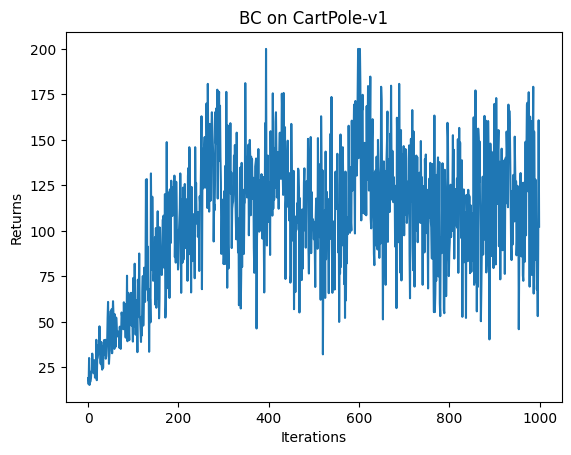

In [19]:
iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()

BC在数据量不够大的情况下确实学不好（这里样本数如果增加到200就可以学到最优策略）

In [ ]:
"""Discriminator是二分类网络，在这里用sigmoid激活和二分类损失函数"""

class Discriminator(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))


In [23]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim,
                                           action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = torch.tensor(expert_s, dtype=torch.float).to(device)
        expert_actions = torch.tensor(expert_a).to(device)
        agent_states = torch.tensor(agent_s, dtype=torch.float).to(device)
        agent_actions = torch.tensor(agent_a).to(device)
        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = torch.nn.BCELoss()(
            agent_prob, torch.ones_like(agent_prob)) + torch.nn.BCELoss()(
                expert_prob, torch.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)


env.reset(seed=0)
torch.manual_seed(0)
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()[0]
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        steps = 0
        while not done and steps < 200:
            steps += 1
            action = agent.take_action(state)
            next_state, reward, done, _, __ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list,
                   next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条:   0%|          | 0/500 [00:00<?, ?it/s]

进度条: 100%|██████████| 500/500 [00:36<00:00, 13.63it/s, return=200.000]


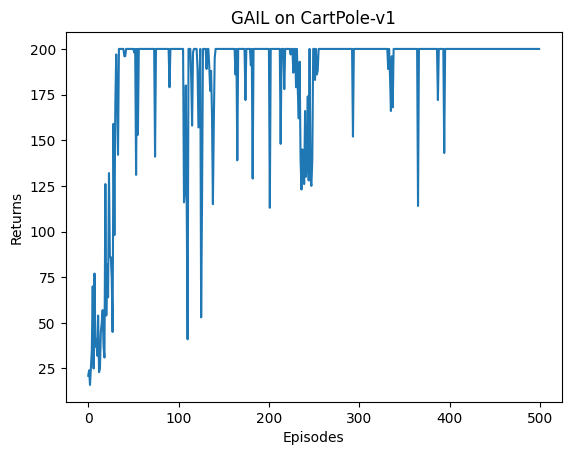

In [24]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))
plt.show()

逆向强化学习（IRL）也是模仿学习中的重要方法，它假设环境的奖励函数应该使得专家轨迹获得最高的奖励值，进而学习背后的奖励函数，最后基于该奖励函数做正向强化学习，从而得到模仿策略

与GAIL相关的还有GAN,即生成式对抗神经网络